In [2]:
from env.dr_env import DemandResponseEnv
from dra.ppo_agent import PPOAgent
import numpy as np
import torch

In [3]:
data_path = "../data/synthetic"
env = DemandResponseEnv(data_path)

obs_dim = len(env.reset())
act_dim = 1  # Since PPO gives a scalar price signal

agent = PPOAgent(obs_dim, act_dim)

In [14]:
num_episodes = 1500

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, logprob = agent.select_action(obs)

        # Broadcast action to all houses if needed
        if np.isscalar(action):
            action = np.full(env.n_houses, action)

        next_obs, reward, done, info = env.step(action)

        agent.store_transition(obs, action, logprob, reward, done)

        obs = next_obs
        total_reward += reward

    agent.train()

    print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}")

[PPO Update] Epoch 1/10 actor_loss=0.2762, critic_loss=3668.3997, entropy=1.9289
[PPO Update] Epoch 2/10 actor_loss=0.2762, critic_loss=3668.2725, entropy=1.9292
[PPO Update] Epoch 3/10 actor_loss=0.2762, critic_loss=3668.1433, entropy=1.9295
[PPO Update] Epoch 4/10 actor_loss=0.2762, critic_loss=3668.0100, entropy=1.9298
[PPO Update] Epoch 5/10 actor_loss=0.2762, critic_loss=3667.8694, entropy=1.9301
[PPO Update] Epoch 6/10 actor_loss=0.2762, critic_loss=3667.7207, entropy=1.9304
[PPO Update] Epoch 7/10 actor_loss=0.2762, critic_loss=3667.5627, entropy=1.9307
[PPO Update] Epoch 8/10 actor_loss=0.2762, critic_loss=3667.3953, entropy=1.9310
[PPO Update] Epoch 9/10 actor_loss=0.2762, critic_loss=3667.2188, entropy=1.9313
[PPO Update] Epoch 10/10 actor_loss=0.2762, critic_loss=3667.0312, entropy=1.9316
Episode 1, Total Reward: -681.93
[PPO Update] Epoch 1/10 actor_loss=0.2740, critic_loss=3641.5793, entropy=1.9319
[PPO Update] Epoch 2/10 actor_loss=0.2740, critic_loss=3641.3828, entropy=1

In [15]:
# Store evaluation results
eval_rewards = []
eval_temperatures = []
eval_power_used = []
eval_prices = []

obs = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = agent.select_action(obs)

    if np.isscalar(action):
        action = np.full(env.n_houses, action)

    obs, reward, done, info = env.step(action)

    # Collect info
    total_reward += reward
    eval_rewards.append(reward)
    eval_temperatures.append(info["avg_indoor_temp"])
    eval_power_used.append(info["total_power"])
    eval_prices.append(info["price"])

print(f"Evaluation complete — Total Reward: {total_reward:.2f}")

Evaluation complete — Total Reward: 88.63


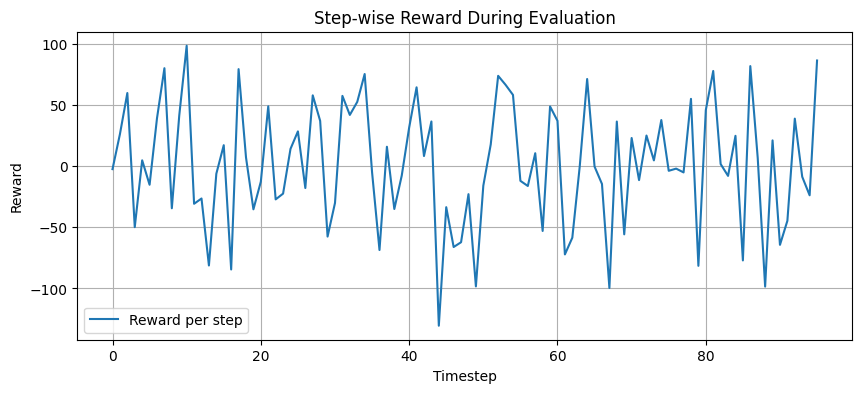

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(eval_rewards, label='Reward per step')
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Step-wise Reward During Evaluation")
plt.grid(True)
plt.legend()
plt.show()

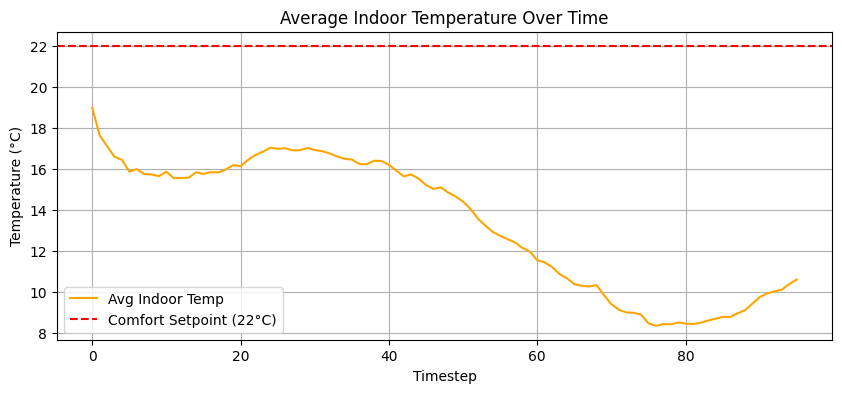

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(eval_temperatures, label='Avg Indoor Temp', color='orange')
plt.axhline(22, color='red', linestyle='--', label='Comfort Setpoint (22°C)')
plt.xlabel("Timestep")
plt.ylabel("Temperature (°C)")
plt.title("Average Indoor Temperature Over Time")
plt.grid(True)
plt.legend()
plt.show()

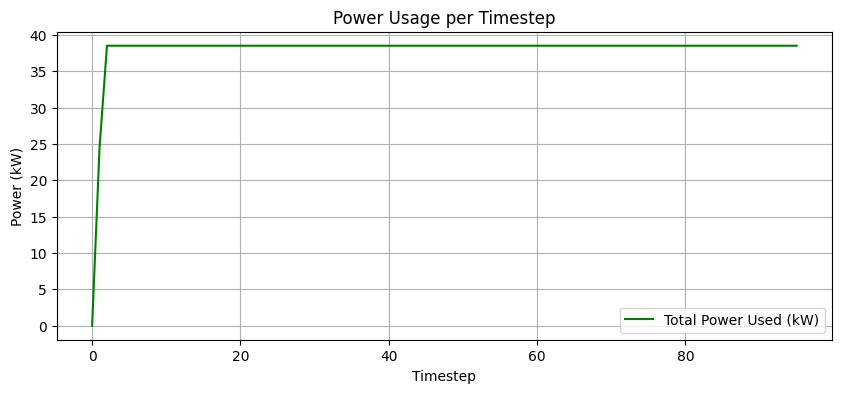

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(eval_power_used, label='Total Power Used (kW)', color='green')
plt.xlabel("Timestep")
plt.ylabel("Power (kW)")
plt.title("Power Usage per Timestep")
plt.grid(True)
plt.legend()
plt.show()

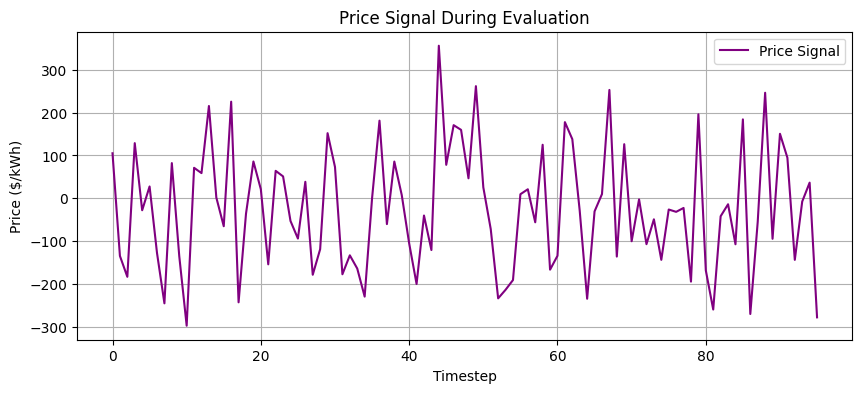

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(eval_prices, label='Price Signal', color='purple')
plt.xlabel("Timestep")
plt.ylabel("Price ($/kWh)")
plt.title("Price Signal During Evaluation")
plt.grid(True)
plt.legend()
plt.show()


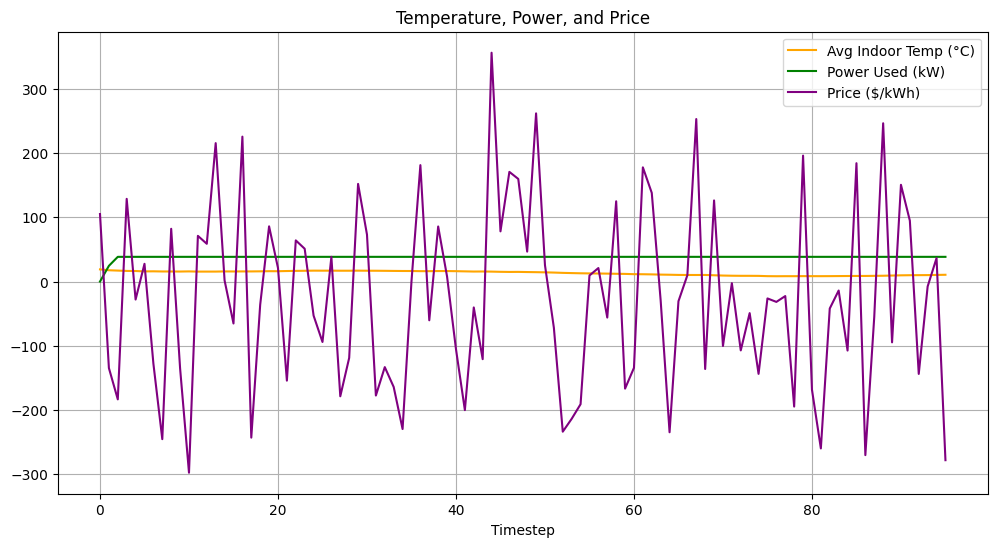

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(eval_temperatures, label='Avg Indoor Temp (°C)', color='orange')
plt.plot(eval_power_used, label='Power Used (kW)', color='green')
plt.plot(eval_prices, label='Price ($/kWh)', color='purple')
plt.xlabel("Timestep")
plt.title("Temperature, Power, and Price")
plt.legend()
plt.grid(True)
plt.show()

📉 1. Step-wise Reward During Evaluation
	•	Interpretation:
The reward starts around -2 but gradually drops to **~ -12** before recovering slightly.
	•	What this means:
	•	The PPO agent likely starts with somewhat efficient pricing, but as time progresses, either the indoor temperatures drift or power is overused, worsening comfort and cost.
	•	This is a sign of partial policy convergence, but it still struggles with maintaining consistent rewards throughout.

⸻

🌡️ 2. Average Indoor Temperature Over Time
	•	Key Observation:
Temperature drops far below the 22°C setpoint (even hitting ~8°C).
	•	Implication:
	•	The agent isn’t preserving comfort, likely undervaluing heating to save energy cost.
	•	This imbalance is driving comfort penalties and is reflected in the decreasing reward trend.

⸻

⚡ 3. Power Usage per Timestep
	•	Observation:
Constant at ~38.5 kW after timestep 1.
	•	Implication:
	•	This suggests agents are fully turning on heating and never turning off.
	•	Possibly due to poor price-to-power calibration — the agent might be ignoring price or perceiving all prices as affordable.
	•	Could indicate lack of regularization or overfitting in the actor policy.

⸻

💲 4. Price Signal During Evaluation
	•	Observation:
Prices range from -5 to 0 $/kWh, fluctuating rapidly.
	•	Implication:
	•	Prices are mostly negative, meaning the agent gets rewarded for using power, which is not realistic.
	•	Likely a bug in your price generation or negative reward scaling — prices should generally be positive or dynamic, not reward-inducing.

⸻

📊 5. Combined Plot: Temp, Power, and Price
	•	Super useful!
	•	Confirms:
	•	Power stays at maximum.
	•	Temp continuously drops.
	•	Prices are negative.
